In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%cd "/gdrive/My Drive"

/gdrive/My Drive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import math

from tqdm import tqdm
import joblib

## config

In [0]:
INPUT = './analysis/mole/data/raw/'
TRAIN_PATH = INPUT + 'train.csv'
TEST_PATH = INPUT + 'test.csv'
PREPROCESS = './analysis/mole/data/preprocess/'

RUN_PLOT = False
TARGET = 'scalar_coupling_constant'
N_FOLDS = 4
ATOM_W = {'H': 1.008, 'C': 12.01, 'N': 14.01, 'O': 16.00}

## logging

In [0]:
import logging
import logging.handlers


def create_logger(log_file_name):
    logger_ = logging.getLogger('main')
    logger_.setLevel(logging.DEBUG)
    fh = logging.handlers.RotatingFileHandler(
        log_file_name, maxBytes=100000, backupCount=8)
    fh.setLevel(logging.DEBUG)
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        '[%(levelname)s]%(asctime)s:%(name)s:%(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    # add the handlers to the logger
    logger_.addHandler(fh)
    logger_.addHandler(ch)


def get_logger():
    return logging.getLogger('main')

## util

In [0]:
def onehot(_df):
    cat_names = [name for name, col in _df.iteritems() if col.dtype == 'O']
    df_cat = pd.get_dummies(_df[cat_names])
    _df = pd.concat([_df, df_cat], axis=1).drop(cat_names, axis=1)
    return _df

def label_encode(df):
    cat_names = [name for name, col in df.iteritems() if col.dtype == 'O']    
    for cat_name in cat_names:
        print(cat_name)
        le = LabelEncoder()
        le.fit(df[cat_name].values)
        df[cat_name] = le.transform(df[cat_name].values)
    return df

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [0]:
def divide_type(df):    
    df['type_0'] = df['type'].apply(lambda x: x[0]).astype(np.uint8)
    df['type_1'] = df['type'].apply(lambda x: x[1:])
    return df

In [0]:
def map_atom_info(df, strct, atom_idx):
    df = pd.merge(df, strct, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

def calc_dist(df):
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values

    df['dist'] = np.linalg.norm(p_0 - p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2

    return df

## EDA + Preprocess

In [0]:
df_train = pd.read_csv(TRAIN_PATH)
df_train = divide_type(df_train)

In [0]:
df_train['type'].unique()

array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'],
      dtype=object)

Joint type:  
1JHC, 1JHN, 2JHH, 2JHN, 3JHH, 3JHC, 3JHN

In [0]:
if RUN_PLOT:
    fig, ax  = plt.subplots(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(df_train[TARGET])

    plt.subplot(1, 2, 2)
    sns.boxplot(x='type', y=TARGET, data=df_train)

- target distribution is divided around 0 and 80.
- predict target from type approximately.
  (e.g. 2JHN is 0)

- idea: clasify above 50 or under 50.

In [0]:
df_strct = pd.read_csv(INPUT + 'structures.csv')
df_strct.head(10)

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602


In [0]:
# the number of molecules
len(df_strct['molecule_name'].unique())

130775

In [0]:
# max of the number of atoms in a molecule
df_strct['atom_index'].max()

28

In [0]:
# df_train = map_atom_info(df_train, df_strct, 0)
# df_train = map_atom_info(df_train, df_strct, 1)
# df_train = calc_dist(df_train)

In [0]:
if RUN_PLOT:
    fig, ax  = plt.subplots(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.distplot(df_train['dist'])

    plt.subplot(1, 2, 2)
    sns.boxplot(x='type', y='dist', data=df_train)

- Angle feature: https://www.kaggle.com/kmat2019/effective-feature
- bonds: https://www.kaggle.com/asauve/dataset-with-number-of-bonds-between-atoms

In [0]:
if RUN_PLOT:
    fig, ax  = plt.subplots(figsize=(15, 4))
    count_type = df_train.groupby(by='type')['id'].count().reset_index()
    plt.subplot(1, 2, 1)
    sns.barplot(data=count_type, x='type', y='id')

    df_test = pd.read_csv(TEST_PATH)
    count_type = df_test.groupby(by='type')['id'].count().reset_index()
    plt.subplot(1, 2, 2)
    sns.barplot(data=count_type, x='type', y='id')

drawing 1JHC
drawing 1JHN
drawing 2JHC
drawing 2JHH
drawing 2JHN
drawing 3JHC
drawing 3JHH
drawing 3JHN


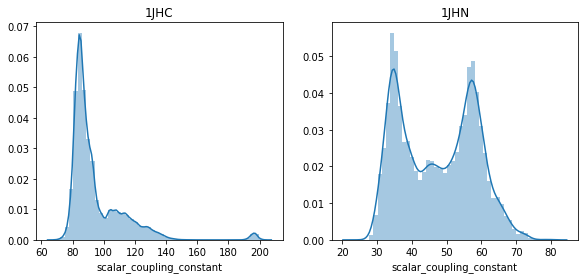

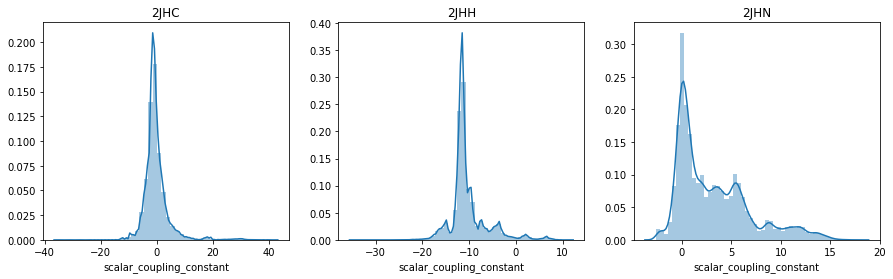

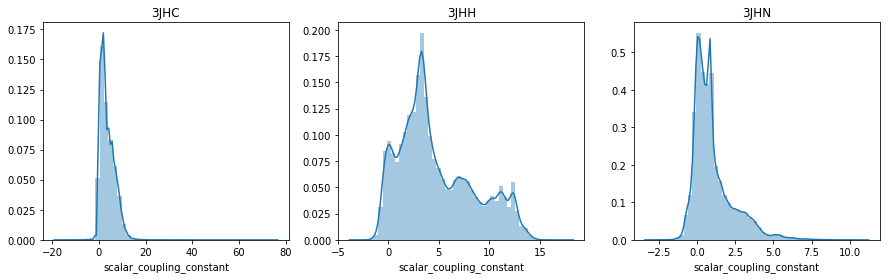

In [0]:
# draw 1J
fig, ax  = plt.subplots(figsize=(15, 4))
print('drawing 1JHC')
plt.subplot(1, 3, 1)
sns.distplot(df_train[df_train['type']=='1JHC'][TARGET])
text = plt.title('1JHC')

print('drawing 1JHN')
plt.subplot(1, 3, 2)
sns.distplot(df_train[df_train['type']=='1JHN'][TARGET])
text = plt.title('1JHN')

# draw 2J
fig, ax  = plt.subplots(figsize=(15, 4))
print('drawing 2JHC')
plt.subplot(1, 3, 1)
sns.distplot(df_train[df_train['type']=='2JHC'][TARGET])
text = plt.title('2JHC')

print('drawing 2JHH')
plt.subplot(1, 3, 2)
sns.distplot(df_train[df_train['type']=='2JHH'][TARGET])
text = plt.title('2JHH')

print('drawing 2JHN')
plt.subplot(1, 3, 3)
sns.distplot(df_train[df_train['type']=='2JHN'][TARGET])
text = plt.title('2JHN')

# draw 3J
fig, ax  = plt.subplots(figsize=(15, 4))
print('drawing 3JHC')
plt.subplot(1, 3, 1)
sns.distplot(df_train[df_train['type']=='3JHC'][TARGET])
text = plt.title('3JHC')

print('drawing 3JHH')
plt.subplot(1, 3, 2)
sns.distplot(df_train[df_train['type']=='3JHH'][TARGET])
text = plt.title('3JHH')

print('drawing 3JHN')
plt.subplot(1, 3, 3)
sns.distplot(df_train[df_train['type']=='3JHN'][TARGET])
text = plt.title('3JHN')

In [0]:
# df_scc = pd.read_csv(INPUT + 'scalar_coupling_contributions.csv')
# df_scc.head()

In [0]:
def plot_scc(df, type_name):
    tmp = df[df['type'] == type_name]
    
    fig, ax = plt.subplots(figsize=(20, 4))
    
    print('plotting fc')
    plt.subplot(1, 4, 1)
    sns.distplot(tmp['fc'])
    text = plt.title(type_name)
    
    print('plotting sd')
    plt.subplot(1, 4, 2)
    sns.distplot(tmp['sd'])
    
    print('plotting pso')
    plt.subplot(1, 4, 3)
    sns.distplot(tmp['pso'])
    
    print('plotting dso')
    plt.subplot(1, 4, 4)
    sns.distplot(tmp['dso'])

def plot_all_scc(df):
    coupling_types = df['type'].unique()
    
    for coupling_type in coupling_types:
        plot_scc(df, coupling_type)            

if RUN_PLOT:
    plot_all_scc(df_scc)

## calculate angel

In [0]:
# merge train and test set
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [0]:
df_all = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_all = df_all[df_train.columns]
df_all = divide_type(df_all)
display(df_all.head())
display(df_all.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,JHC
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,JHH
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,JHH
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,JHH
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,JHC


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
7163684,7163684,dsgdb9nsd_133885,15,3,2JHC,NaN,2,JHC
7163685,7163685,dsgdb9nsd_133885,15,4,2JHC,NaN,2,JHC
7163686,7163686,dsgdb9nsd_133885,15,6,3JHC,NaN,3,JHC
7163687,7163687,dsgdb9nsd_133885,15,7,2JHC,NaN,2,JHC
7163688,7163688,dsgdb9nsd_133885,15,8,1JHC,NaN,1,JHC


In [0]:
def read_bonds():
    train_bond = pd.read_csv(PREPROCESS + 'train_bonds.csv')
    test_bond = pd.read_csv(PREPROCESS + 'test_bonds.csv')
    
    df = pd.concat([train_bond, test_bond], axis=0, ignore_index=True)
    df.drop(['Unnamed: 0', 'L2dist'], axis=1, inplace=True)
    
    return df

In [0]:
df_bonds = read_bonds()
# df_charges = pd.read_csv(PREPROCESS + 'train_charges.csv')

display(df_bonds.head())
display(df_bonds.tail())

,molecule_name,atom_index_0,atom_index_1,nbond,error,bond_type
0,dsgdb9nsd_000001,0,1,1.0,0,1.0CH
1,dsgdb9nsd_000001,0,2,1.0,0,1.0CH
2,dsgdb9nsd_000001,0,3,1.0,0,1.0CH
3,dsgdb9nsd_000001,0,4,1.0,0,1.0CH
4,dsgdb9nsd_000002,0,1,1.0,0,1.0HN


,molecule_name,atom_index_0,atom_index_1,nbond,error,bond_type
2439656,dsgdb9nsd_133885,3,8,1.0,0,1.0CC
2439657,dsgdb9nsd_133885,3,4,1.0,0,1.0CC
2439658,dsgdb9nsd_133885,4,8,1.0,0,1.0CC
2439659,dsgdb9nsd_133885,6,7,1.0,0,1.0CC
2439660,dsgdb9nsd_133885,7,8,1.0,0,1.0CC


In [0]:
df_1j = df_all[df_all['type_0'] == 1]
display(df_1j.head())

df_2j = df_all[df_all['type_0'] == 2]
display(df_2j.head())

df_3j = df_all[df_all['type_0'] == 3]
display(df_3j.head())

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,JHC
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,JHC
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,JHC
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,JHC
10,10,dsgdb9nsd_000002,1,0,1JHN,32.6889,1,JHN


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,JHH
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,JHH
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,JHH
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,2,JHH
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,2,JHH


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
23,23,dsgdb9nsd_000007,2,5,3JHH,3.25281,3,JHH
24,24,dsgdb9nsd_000007,2,6,3JHH,13.69130,3,JHH
25,25,dsgdb9nsd_000007,2,7,3JHH,3.25205,3,JHH
29,29,dsgdb9nsd_000007,3,5,3JHH,13.69240,3,JHH
30,30,dsgdb9nsd_000007,3,6,3JHH,3.25253,3,JHH


## get adjacent matrix

In [0]:
def get_adjacent_mat(df):
    """
    Parameters
    ----------
    df: pd.DataFrame
        dataframe of a molecular
    """    
    # edge is bond between atoms
    edges = df[['atom_index_0', 'atom_index_1']].values    
    edges = edges.transpose(1, 0)
    
    # the number of bonds
    n_bonds = df['nbond'].values
    
    # the number of nodes may be max of atom index.
    n_nodes = edges.max() + 1 
    # initialize adjacent matrix
    mat = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    
    # 1 bond
    is_the_bond = (n_bonds == 1)
    mat[edges[0][is_the_bond], edges[1][is_the_bond]] = 1
    # 2 bond
    is_the_bond = (n_bonds == 2)
    mat[edges[0][is_the_bond], edges[1][is_the_bond]] = 2
    # 3 bond
    is_the_bond = (n_bonds == 3)
    mat[edges[0][is_the_bond], edges[1][is_the_bond]] = 3
    
    mat += mat.transpose(1, 0)
    
    return mat

In [0]:
def get_adjacent_mat_old(df):
    """
    Parameters
    ----------
    df: pd.DataFrame
        dataframe of a molecular
    """
    # edge is bond between atoms
    edges = df[['atom_index_0', 'atom_index_1']].values    
    edges = edges.transpose(1, 0)
    
    # the number of bonds
    n_bonds = df['nbond'].values
      
    n_nodes = edges.max() + 1 
    # adjacent matrix
    mat = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    mat[edges[0], edges[1]] = 1
    mat += mat.transpose(1, 0)
    return mat

In [0]:
# groups = df_bonds.groupby('molecule_name')
# groups.__iter__ returns (name, df_group)
# adj_mat = {g[0]: get_adjacent_mat(g[1])  for g in tqdm(groups)}

adj_mat = joblib.load(PREPROCESS + 'adj_mat.pkl')
adj_mat2 = {name: np.matmul(mat, mat) for name, mat in adj_mat.items()}

In [0]:
# TODO: bug fix
display(df_2j[df_2j.index==104493])
# print(df_2j.iloc[104493, :])
# df_2j[df_2j['molecule_name'] == 'dsgdb9nsd_004015']

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1
104493,104493,dsgdb9nsd_004015,2,4,2JHC,1.03505,2,JHC


## some features for 1JHC, 1JHN
1JHC is correlated with the hybridization of the C-H bonding orbital. sp3 sp2 sp

In [0]:
def trans_bonds(s, adjacent_matrix):
    """
    Get the number of bonds of C or N from atom index.
    
    Parameters
    ----------
    s: pd.Series
        s must have 'molecule_name', 'atom_index_1'
    adjacent_matrix: dict
    """
    mole_name = s['molecule_name']
    idx = s['atom_index_1']
    n_bonds = (adjacent_matrix[mole_name][:, idx] > 0).sum()
    
    return n_bonds

def some_1j(df_1j, strct, adjacent_matrix):
    # get atom string(e.g., 'C') from atom_index
    df_1j = map_atom_info(df_1j, strct, 0)
    df_1j = map_atom_info(df_1j, strct, 1)
    display(df_1j.head())
    
    assert (df_1j['atom_1']!='H').sum() == df_1j.shape[0], 'atom_index_1 is not an index column of C or N.'

    df_1j['1j_nbonds'] = df_1j[['molecule_name', 'atom_index_1']].apply(trans_bonds, axis=1, adjacent_matrix=adjacent_matrix)
    
    ret = df_1j[['molecule_name', 'atom_index_0', 'atom_index_1', '1j_nbonds']]
    display(ret.head())
    return ret

In [0]:
assert (df_1j['atom_1']!='H').sum() == df_1j.shape[0], 'atom_index_1 is not an index column of C or N.'

df_1j.head()


KeyError: ignored

In [0]:
def trans_bonds(s, adjacent_matrix):
    """
    Get the number of bonds of C or N from atom index.
    
    Parameters
    ----------
    s: pd.Series
        s must have 'molecule_name', 'atom_index_1'
    adjacent_matrix: dict
    """
    mole_name = s['molecule_name']
    idx = s['atom_index_1']
    n_bonds = (adjacent_matrix[mole_name][:, idx] > 0).sum()
    
    return n_bonds

df_1j['1j_nbonds'] = df_1j[['molecule_name', 'atom_index_1']].apply(trans_bonds, axis=1, adjacent_matrix=adj_mat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
%%time
def add_neighbor_atoms(s, groups, adjacent_matrix):
    # print(s)
    cn_idx = s['atom_index_1']
    h_idx = s['atom_index_0']
    mole_name = s['molecule_name']
    # print(h_idx)
    # print(cn_idx)
    
    neighbor_tf = adjacent_matrix[mole_name][cn_idx] > 0
    neighbor_tf[h_idx] = False
    
    # print(neighbor_tf)
    
    mole_group = mole_groups.get_group(mole_name)
    neighbor_atoms = mole_group.loc[neighbor_tf, 'atom']
    neighbor_atoms.values.sort()
    neighbor_atoms_str = ''.join(neighbor_atoms)
    
    # print(neighbor_atoms_str)
    return neighbor_atoms_str

mole_groups = df_strct.groupby(by='molecule_name')
df_1j['neighbor_atoms'] = df_1j[['molecule_name', 'atom_index_0', 'atom_index_1']].apply(add_neighbor_atoms, groups=mole_groups, adjacent_matrix=adj_mat, axis=1)

CPU times: user 16min 32s, sys: 5.62 s, total: 16min 37s
Wall time: 16min 28s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
def add_neighbor_weight(atom_str):
    return sum([ATOM_W[c] for c in atom_str])
    
df_1j['neighbor_weight'] = df_1j['neighbor_atoms'].transform(add_neighbor_weight)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
df_1j.head(100)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1,neighbor_atoms,1j_nbonds,neighbor_weight
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,JHC,HHH,4,3.024
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,JHC,HHH,4,3.024
7,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,JHC,HHH,4,3.024
9,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,JHC,HHH,4,3.024
10,10,dsgdb9nsd_000002,1,0,1JHN,32.6889,1,JHN,HH,3,2.016
13,13,dsgdb9nsd_000002,2,0,1JHN,32.6891,1,JHN,HH,3,2.016
15,15,dsgdb9nsd_000002,3,0,1JHN,32.6905,1,JHN,HH,3,2.016
17,17,dsgdb9nsd_000005,2,0,1JHC,171.2200,1,JHC,N,2,14.010
19,19,dsgdb9nsd_000007,2,0,1JHC,83.5429,1,JHC,CHH,4,14.026
26,26,dsgdb9nsd_000007,3,0,1JHC,83.5417,1,JHC,CHH,4,14.026


In [0]:
df_1j['1j_nbonds'].value_counts()

4    992763
3    141458
2     23362
Name: 1j_nbonds, dtype: int64

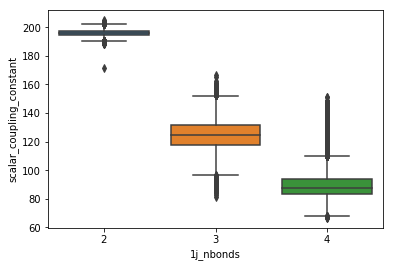

In [0]:
tmp = df_1j[df_1j['type']=='1JHC']
sns.boxplot(x='1j_nbonds', y=TARGET, data=tmp)

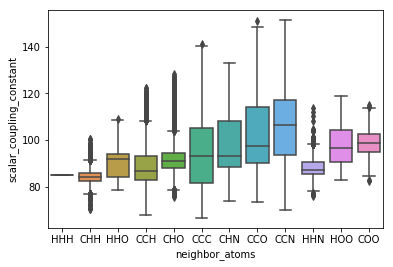

In [0]:
tmp = df_1j[(df_1j['type']=='1JHC') & (df_1j['1j_nbonds']==4)]
sns.boxplot(x='neighbor_atoms', y=TARGET, data=tmp)
# sns.scatterplot(x='neighbor_weight', y=TARGET, data=tmp)

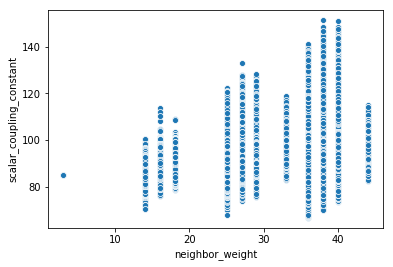

In [0]:
sns.scatterplot(x='neighbor_weight', y=TARGET, data=tmp)

In [0]:
joblib.dump(df_1j[['molecule_name', 'atom_index_0', 'atom_index_1', '1j_nbonds', 'neighbor_atoms', 'neighbor_weight']], 'df_1j.pkl')

['df_1j.pkl']

In [0]:
df_1j_dash = joblib.load('df_1j.pkl')

In [0]:
df_1j = df_1j.merge(df_1j_dash, on=['molecule_name', 'atom_index_0', 'atom_index_1'], how='left')
df_1j.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1,1j_nbonds,neighbor_atoms,neighbor_weight
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,1,JHC,4,HHH,3.024
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,1,JHC,4,HHH,3.024
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,1,JHC,4,HHH,3.024
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,1,JHC,4,HHH,3.024
4,10,dsgdb9nsd_000002,1,0,1JHN,32.6889,1,JHN,3,HH,2.016


## get intercept atoms and get some features

In [0]:
def get_intercept_atom_2j(s, adjacent_matrix):
    mole_name, idx0, idx1 = s
    
    connected_atom0 = adjacent_matrix[mole_name][:, idx0]
    connected_atom1 = adjacent_matrix[mole_name][:, idx1]
    intercept_atom = np.where(connected_atom0 * connected_atom1 > 0)[0]
    if len(intercept_atom) != 1:
        return -1
        # TODO: bug fix
        # raise ValueError('The number of intercept atoms is %d at %s' % (len(intercept_atom), mole_name))
    intercept_atom_idx = intercept_atom[0]
    # print(intercept_atom_idx)
    return intercept_atom_idx

def get_intercept_atom_3j(s, adjacent_matrix, adjacent_matrix2):
    ret_idx_0 = -1
    ret_idx_1 = -1
    
    mole_name, idx0, idx1 = s
    
    # atom, that be arrived by 1-path from idx0 and 2-path from idx1
    connected_atom0 = adjacent_matrix[mole_name][:, idx0]
    connected_atom1 = adjacent_matrix2[mole_name][:, idx1]
    # np.where returns (array[], )
    intercept_atom = np.where(connected_atom0 * connected_atom1 > 0)[0]    
    
    if len(intercept_atom) != 1:        
        return -1, -1
        # TODO: bug fix
        # raise ValueError('The number of intercept atoms is %d at %s' % (len(intercept_atom), mole_name))    
    else:
        ret_idx_0 = intercept_atom[0]
    
    # atom, that be arrived by 2-path from idx0 and 1-path from idx1
    connected_atom0 = adjacent_matrix2[mole_name][:, idx0]
    connected_atom1 = adjacent_matrix[mole_name][:, idx1]
    # np.where returns (array[], )
    intercept_atom = np.where(connected_atom0 * connected_atom1 > 0)[0]
    if len(intercept_atom) != 1:        
        return -1, -1
        # TODO: bug fix
        # raise ValueError('The number of intercept atoms is %d at %s' % (len(intercept_atom), mole_name))    
    else:
        ret_idx_1 = intercept_atom[0]
    
    return ret_idx_0, ret_idx_1

In [0]:
def get_xyz(df, strct, idx_col, xyz_suffix, get_atom_name=False):
    """
    Parameters
    ----------
    df: pd.DataFrame
    stcrt: pd.DataFrame
    idx_col: str
        column name according to atom_index in df. 
        e.g. atom_index_0
    xyz_suffix: str
        suffix to append to 'x', 'y', 'z'
        if suffix is '0', create 'x0', 'y0', 'z0'
    get_atom_name: bool
        whether get 'atom' column
    
    Returns
    -------
    ret: pd.DataFrame
        shape of [n_samples, 3]. [n_samples, 4] if get_atom_name is True.
        e.g. the columns are 'x0', 'y0', 'z0', 'atom0'
    """
    rename_dict = {
        'x': 'x'+xyz_suffix, 
        'y': 'y'+xyz_suffix, 
        'z': 'z'+xyz_suffix        
    }
    
    if get_atom_name:
        atom_col = ['atom']
        rename_dict['atom'] = 'atom'+xyz_suffix
    else:
        atom_col = []
        
    ret = df[['molecule_name', idx_col]].merge(
        strct[['molecule_name', 'atom_index', 'x', 'y', 'z'] + atom_col],
        left_on=['molecule_name', idx_col],
        right_on=['molecule_name', 'atom_index'],
        how='left'
    )\
    .drop(['molecule_name', idx_col, 'atom_index'], axis=1)\
    .rename(columns=rename_dict)
    
    return ret

def normalize(x):
    """
    Parameters
    ----------
    x: np.ndarray
    
    Returns
    -------
    norm_vec: np.ndarray, shape of [n_samples, n_features]
    norm: np.ndarray, shape of [n_samples, 1]
    """
    norm = np.linalg.norm(x, axis=1, keepdims=True)
    return x / norm, norm

def get_cos_2j(df, strct):
    """
    Parameters
    ----------
    df: pd.DataFrame
        df must be has `atom_index_0`, `atom_index_1`, `center_index` columns.
    """
    tmp1 = get_xyz(df, df_strct, 'atom_index_0', '0')
    tmp2 = get_xyz(df, df_strct, 'atom_index_1', '1')
    tmp3 = get_xyz(df, df_strct, 'center_index', '2', get_atom_name=True)    
    
    # get vector
    vec_02 = tmp3[['x2', 'y2', 'z2']].values - tmp1[['x0', 'y0', 'z0']].values
    vec_12 = tmp3[['x2', 'y2', 'z2']].values - tmp2[['x1', 'y1', 'z1']].values
    
    # get area using vector product between two vectors(vec_20 x vec_21)
    nvec_021 = np.cross(-vec_02, -vec_12)
    _, area_021 = normalize(nvec_021)
    
    # get l2-normalized vectors
    vec_02, norm_vec_02 = normalize(vec_02)
    vec_12, norm_vec_12 = normalize(vec_12)
    
    # cosine similarity
    cos_021 = (vec_02 * vec_12).sum(axis=1)
    
    ret = df[['molecule_name', 'atom_index_0', 'atom_index_1']]
    ret['2j_atom_center'] = tmp3['atom2'].values
    ret['2j_area_021'] = area_021
    ret['2j_norm_vec_02'] = norm_vec_02
    ret['2j_norm_vec_12'] = norm_vec_12
    ret['2j_cos'] = cos_021
    
    return ret

def get_cos_3j(df, strct):
    """
    Parameters
    ----------
    df: pd.DataFrame
        df must be has `atom_index_0`, `atom_index_1`, `center_index_0`, `center_index_1` columns.
    """
    tmp0 = get_xyz(df, df_strct, 'atom_index_0', '0')
    tmp1 = get_xyz(df, df_strct, 'atom_index_1', '1')
    tmp2 = get_xyz(df, df_strct, 'center_index_0', '2', get_atom_name=True)
    tmp3 = get_xyz(df, df_strct, 'center_index_1', '3', get_atom_name=True)
    
    # get vector
    vec_02 = tmp2[['x2', 'y2', 'z2']].values - tmp0[['x0', 'y0', 'z0']].values
    vec_13 = tmp3[['x3', 'y3', 'z3']].values - tmp1[['x1', 'y1', 'z1']].values
    vec_23 = tmp3[['x3', 'y3', 'z3']].values - tmp2[['x2', 'y2', 'z2']].values
        
    # get dihedral
    # 1. get two normal vectors of two planes using vector product
    # 2. get cos similarity of the normal vectors
    # normal vector(vec_20 x vec23)
    nvec_023 = np.cross(-vec_02, vec_23)
    # normal vector(vec_32 x vec 31)
    nvec_231 = np.cross(-vec_23, -vec_13)
    # cos similarity
    nvec_023, area_023 = normalize(nvec_023)
    nvec_231, area_231 = normalize(nvec_231)
    dihedral = (nvec_023 * nvec_231).sum(axis=1)
    
    # get cosine similarity
    # get l2-normalized vectors
    # get norm 
    vec_02, norm_vec_02 = normalize(vec_02)
    vec_13, norm_vec_13 = normalize(vec_13)
    vec_23, norm_vec_23 = normalize(vec_23)
    # cosine 0-2-3
    cos_023 = (vec_02 * -vec_23).sum(axis=1)
    # cosine 2-3-1
    cos_231 = (vec_23 * vec_13).sum(axis=1)

    
    ret = df[['molecule_name', 'atom_index_0', 'atom_index_1']]
    ret['3j_atom_center_0'] = tmp2['atom2'].values
    ret['3j_atom_center_1'] = tmp3['atom3'].values
    ret['3j_norm_vec_02'] = norm_vec_02
    ret['3j_norm_vec_13'] = norm_vec_13
    ret['3j_norm_vec_23'] = norm_vec_23
    ret['3j_cos_023'] = cos_023
    ret['3j_cos_231'] = cos_231
    ret['3j_area_023'] = area_023
    ret['3j_area_231'] = area_231
    ret['3j_dihedral'] = dihedral
    
    return ret

In [0]:

df_2j['center_index'] = df_2j[['molecule_name', 'atom_index_0', 'atom_index_1']].apply(get_intercept_atom_2j, adjacent_matrix=adj_mat, axis=1)
display(df_2j.head())
df_2jsim = get_cos_2j(df_2j, df_strct)
df_2jsim.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1,center_index
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,2,JHH,0
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,2,JHH,0
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,2,JHH,0
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.2541,2,JHH,0
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.2548,2,JHH,0


NameError: ignored

In [0]:
joblib.dump(df_2jsim, 'df_2jsim.pkl')

['df_2jsim.pkl']

In [0]:
# tmp = df_3j[['molecule_name', 'atom_index_0', 'atom_index_1']].head(1000)
tmp2 = df_3j[['molecule_name', 'atom_index_0', 'atom_index_1']].apply(get_intercept_atom_3j, 
# tmp2 = tmp.apply(get_intercept_atom_3j, 
                                                                     adjacent_matrix=adj_mat, 
                                                                     adjacent_matrix2=adj_mat2, 
                                                                     axis=1,
                                                                     result_type='expand'
                                                                     )
tmp2.rename(columns={0: 'center_index_0', 1: 'center_index_1'}, inplace=True)
df_3j = pd.concat([df_3j, tmp2], axis=1)
# tmp = pd.concat([tmp, tmp2], axis=1)
display(df_3j.tail())
# display(tmp.tail())
df_3jsim = get_cos_3j(df_3j, df_strct)
# df_3jsim = get_cos_3j(tmp, df_strct)
df_3jsim.tail()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type_0,type_1,center_index_0,center_index_1
7163677,7163677,dsgdb9nsd_133885,14,4,3JHC,NaN,3,JHC,7,8
7163681,7163681,dsgdb9nsd_133885,14,15,3JHH,NaN,3,JHH,7,8
7163682,7163682,dsgdb9nsd_133885,15,1,3JHN,NaN,3,JHN,8,7
7163683,7163683,dsgdb9nsd_133885,15,2,3JHC,NaN,3,JHC,8,3
7163686,7163686,dsgdb9nsd_133885,15,6,3JHC,NaN,3,JHC,8,7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,molecule_name,atom_index_0,atom_index_1,3j_atom_center_0,3j_atom_center_1,3j_norm_vec_02,3j_norm_vec_13,3j_norm_vec_23,3j_cos_023,3j_cos_231,3j_area_023,3j_area_231,3j_dihedral
7163677,dsgdb9nsd_133885,14,4,C,C,1.088204,1.537739,1.503272,-0.514613,-0.221471,1.402630,2.254236,-0.463228
7163681,dsgdb9nsd_133885,14,15,C,C,1.088204,1.080482,1.503272,-0.514613,-0.595536,1.402630,1.304814,0.839732
7163682,dsgdb9nsd_133885,15,1,C,C,1.080482,1.563097,1.503272,-0.595536,-0.437273,1.304814,2.113208,-0.403965
7163683,dsgdb9nsd_133885,15,2,C,C,1.080482,1.503272,1.519516,-0.563522,-0.177201,1.356301,2.248096,-0.855315
7163686,dsgdb9nsd_133885,15,6,C,C,1.080482,1.531182,1.503272,-0.595536,-0.137431,1.304814,2.279942,-0.976779


In [0]:
df_3jsim.head()

,molecule_name,atom_index_0,atom_index_1,3j_atom_center_0,3j_atom_center_1,3j_norm_vec_02,3j_norm_vec_13,3j_norm_vec_23,3j_cos_023,3j_cos_231,3j_area_023,3j_area_231,3j_dihedral
23,dsgdb9nsd_000007,2,5,C,C,1.094954,1.094958,1.529629,-0.365575,-0.365562,1.558941,1.558956,0.499958
24,dsgdb9nsd_000007,2,6,C,C,1.094954,1.094953,1.529629,-0.365575,-0.365566,1.558941,1.558947,-1.000000
25,dsgdb9nsd_000007,2,7,C,C,1.094954,1.094968,1.529629,-0.365575,-0.365620,1.558941,1.558931,0.500033
29,dsgdb9nsd_000007,3,5,C,C,1.094958,1.094958,1.529629,-0.365564,-0.365562,1.558954,1.558956,-1.000000
30,dsgdb9nsd_000007,3,6,C,C,1.094958,1.094953,1.529629,-0.365564,-0.365566,1.558954,1.558947,0.499932


In [0]:
joblib.dump(df_3jsim, 'df_3jsim.pkl')

['df_3jsim.pkl']

In [0]:
df_bonds[dtmf_bonds['molecule_name'] == 'dsgdb9nsd_000007']

TODO
- calculate adjacent matrix^2
- 

In [0]:
df_2jsim.to_csv('2j_center_atom.csv', index=False)

In [0]:
(df_2jsim['sim_2j'].isnull()).sum()